* 请在环境变量中设置`DB_URI`指向数据库

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
from PyFin.api import *
from alphamind.api import *
from alphamind.strategy.strategy import Strategy, RunningSetting
from matplotlib import pyplot as plt

plt.style.use('ggplot')

In [2]:
# Back test parameter settings
start_date = '2020-01-01'
end_date = '2020-02-21'

freq = '10b'
industry_name = 'sw'
industry_level = 1
turn_over_target = 0.4
batch = 1
horizon = map_freq(freq)
weights_bandwidth = 0.01
universe = Universe('hs300')
data_source = os.environ['DB_URI']
benchmark_code = 300
method = 'risk_neutral'

In [3]:
# Model settings
alpha_factors = {
    'f01': CSQuantiles(LAST('EMA5D')),
    'f02': CSQuantiles(LAST('EMV6D')),
    }

weights = dict(f01=1.,
               f02=1.)

alpha_model = ConstLinearModel(features=alpha_factors, weights=weights)

data_meta = DataMeta(freq=freq,
                     universe=universe,
                     batch=1,
                     neutralized_risk=None,
                     pre_process=None,
                     post_process=None,
                     data_source=data_source)

In [4]:
# Constraintes settings

industry_names = industry_list(industry_name, industry_level)
constraint_risk = ['SIZE', 'SIZENL', 'BETA']
total_risk_names = constraint_risk + ['benchmark', 'total']
all_styles = risk_styles + industry_styles + macro_styles

b_type = []
l_val = []
u_val = []

previous_pos = pd.DataFrame()
rets = []
turn_overs = []
leverags = []

for name in total_risk_names:
    if name == 'benchmark':
        b_type.append(BoundaryType.RELATIVE)
        l_val.append(0.8)
        u_val.append(1.0)
    else:
        b_type.append(BoundaryType.ABSOLUTE)
        l_val.append(0.0)
        u_val.append(0.0)

bounds = create_box_bounds(total_risk_names, b_type, l_val, u_val)

In [5]:
# Running settings
running_setting = RunningSetting(weights_bandwidth=weights_bandwidth,
                                 rebalance_method=method,
                                 bounds=bounds,
                                 turn_over_target=turn_over_target)

In [6]:
# Strategy
strategy = Strategy(alpha_model,
                    data_meta,
                    universe=universe,
                    start_date=start_date,
                    end_date=end_date,
                    freq=freq,
                    benchmark=benchmark_code)

strategy.prepare_backtest_data()
ret_df, positions = strategy.run(running_setting=running_setting)

2021-01-10 02:23:10,565 - ALPHA_MIND - INFO - alpha factor data loading finished ...
2021-01-10 02:23:13,606 - ALPHA_MIND - INFO - industry data loading finished ...
2021-01-10 02:23:27,549 - ALPHA_MIND - INFO - benchmark data loading finished ...
2021-01-10 02:23:43,474 - ALPHA_MIND - INFO - risk_model data loading finished ...
2021-01-10 02:24:14,284 - ALPHA_MIND - INFO - returns data loading finished ...
2021-01-10 02:24:16,913 - ALPHA_MIND - INFO - starting backting ...
2021-01-10 02:24:16,925 - ALPHA_MIND - INFO - alpha models training finished ...
2021-01-10 02:24:16,930 - ALPHA_MIND - INFO - 2020-01-02 00:00:00 re-balance: 300 codes
2021-01-10 02:24:16,959 - ALPHA_MIND - INFO - 2020-01-16 00:00:00 re-balance: 300 codes
2021-01-10 02:24:17,011 - ALPHA_MIND - INFO - 2020-02-07 00:00:00 re-balance: 300 codes
2021-01-10 02:24:17,054 - ALPHA_MIND - INFO - 2020-02-21 00:00:00 re-balance: 300 codes


<AxesSubplot:>

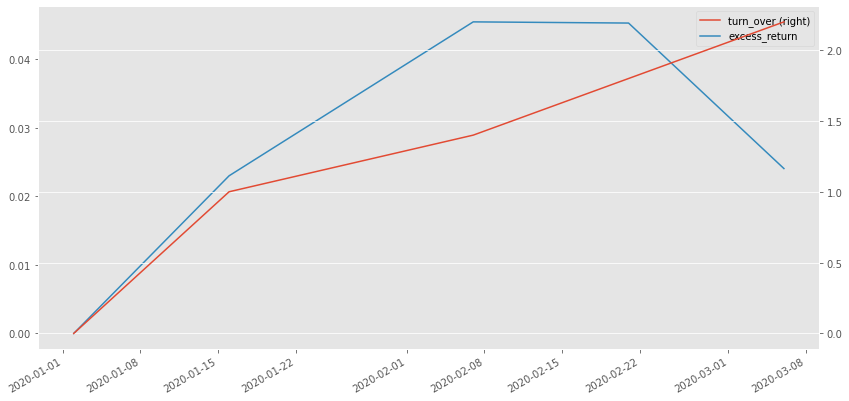

In [7]:
ret_df[['turn_over', 'excess_return']].cumsum().plot(figsize=(14, 7), secondary_y='turn_over')